In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time
import scipy.optimize

In [16]:
d = 0.2
c = 1

In [17]:
#Convection_Diffusion Equation(확산계수는 d=1)
def physics_net(net, xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    with tf.GradientTape(persistent=True) as tape_2:
        tape_2.watch(t)
        tape_2.watch(x)
        with tf.GradientTape(persistent=True) as tape_1:
            tape_1.watch(t)
            tape_1.watch(x)
            xt_t = tf.concat([x,t], axis=1)
            u = net(xt_t)
        u_x = tape_1.gradient(u, x)
        u_t = tape_1.gradient(u, t)
    u_xx = tape_2.gradient(u_x, x)

    return u_t +  c*u_x - d*u_xx
#print(physics_net(NN,tf.convert_to_tensor(xt_col_data, dtype=tf.float32)))

In [18]:
#MSE = MSE_u + MSE_f
def compute_loss(f, u_bnd_hat, u_bnd_sol):

    loss_col = tf.reduce_mean(tf.square(f))
    loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat[100:200]-u_bnd_hat[200:300]))
    loss_ini = tf.reduce_mean(tf.square(u_bnd_hat[:100]-u_bnd_sol[:100]))
    
    loss = loss_col + loss_bnd + loss_ini

    return loss

In [19]:
def compute_grad(net, xt_col, xt_bnd, u_bnd_sol):
    with tf.GradientTape() as tape:
        f = physics_net(net,xt_col)
        u_bnd_hat = net(xt_bnd)

        loss = compute_loss(f, u_bnd_hat, u_bnd_sol)

    grads = tape.gradient(loss, net.trainable_variables) #gradients 계산

    return loss, grads

In [20]:
#어떤 이벤트가 발생했거나 특정 시점에 도달했을 때 시스템에서 호출하는 함수
def callback(arg=None):
    global iter_num
    global instant_loss
    if iter_num % 100 == 0:
        print('iter=', iter_num, ', loss=', instant_loss)
    train_loss_history.append([iter_num, instant_loss])

    iter_num=iter_num+1

In [21]:
def diffusion_data():

    # set number of data points
    N_b = 100    # boundary
    N_t = 100    # initial time
    N_c = 100  # collocation point

    # set boundary
    xmin = -1.0
    xmax = 1.0
    tmin = 0.0
    tmax = 1.0

    # initial condition
    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = (1-np.sin(np.pi * initial_xt[:,0])).reshape(-1,1)

    # boundary condition
    boundary_up = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_up_sol = np.zeros((N_b, 1))
    boundary_down = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_down_sol = np.zeros((N_b, 1))

    # collection of initial and boundary condition
    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)

    t_col_data = np.linspace(tmin, tmax, N_c)
    x_col_data = np.linspace(xmin, xmax, N_c)
    xt_data = []
    for i in t_col_data[1: ]:
        for j in x_col_data[1:99]:
            xt_data.append([j,i])
    xt_col_data = xt_data
    
    # collocation point
    #t_col_data = np.linspace([tmin], [tmax], N_c)
    #x_col_data = np.linspace([xmin], [xmax], N_c)
    #xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate((xt_col_data, xt_bnd), axis=0)

    # convert all to tensors
    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)

    return xt_col, xt_bnd, u_bnd_sol

# L-BFGS-B optimizer

In [22]:
iter_num=1
instant_loss=0
train_loss_history=[]

In [23]:
def save_weights_lbfgs(net):
    net.save_weights('convection_diffusion2.h5')

def load_weights_lbfgs(net):
    net.load_weights('convection_diffusion2.h5')

In [24]:
#레이어와 노드의 수는 이곳에서 변경
initializer = tf.keras.initializers.GlorotUniform #모델의 초기의 가중치 값 설정(균등분포)
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,2)),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 1, activation='linear')
])

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, None, 20)          60        
                                                                 
 dense_12 (Dense)            (None, None, 20)          420       
                                                                 
 dense_13 (Dense)            (None, None, 20)          420       
                                                                 
 dense_14 (Dense)            (None, None, 20)          420       
                                                                 
 dense_15 (Dense)            (None, None, 20)          420       
                                                                 
 dense_16 (Dense)            (None, None, 20)          420       
                                                                 
 dense_17 (Dense)            (None, None, 20)         

In [25]:
#L-BFGS기법을 사용하여 gradients를 통해 backpropagation(weight 갱신)을 진행
def train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):

    def vec_weight():
        # vectorize weights
        weight_vec = []

        # Loop over all weights(위에서 만든 신경망 NN의 layers의학습 가능한 가중치_weight,biasis)
        for v in net.trainable_variables:
            weight_vec.extend(v.numpy().flatten())

        weight_vec = tf.convert_to_tensor(weight_vec)
        return weight_vec
    w0 = vec_weight().numpy()

    def restore_weight(weight_vec):
        # restore weight vector to model weights
        idx = 0
        for v in net.trainable_variables:
            vs = v.shape

            # weight matrices
            if len(vs) == 2:
                sw = vs[0] * vs[1]
                updated_val = tf.reshape(weight_vec[idx:idx + sw], (vs[0], vs[1]))
                idx += sw

            # bias vectors
            elif len(vs) == 1:
                updated_val = weight_vec[idx:idx + vs[0]]
                idx += vs[0]

            # assign variables (Casting necessary since scipy requires float64 type)
            v.assign(tf.cast(updated_val, dtype=tf.float32))


    def loss_grad(w):
        # update weights in model
        restore_weight(w)
        loss, grads = compute_grad(net, xt_col, xt_bnd, u_bnd_sol)
        # vectorize gradients
        grad_vec = []
        for g in grads:
            grad_vec.extend(g.numpy().flatten())

        # gradient list to array
        # scipy-routines requires 64-bit floats
        loss = loss.numpy().astype(np.float64)
        global instant_loss
        instant_loss = loss
        grad_vec = np.array(grad_vec, dtype=np.float64)

        return loss, grad_vec
    
    return scipy.optimize.minimize(fun=loss_grad, #The objective function to be minimized
                                    x0=w0, #Array of real elements of size (n,) as Initial guess
                                    jac=True, 
                                    method='L-BFGS-B',
                                    callback=callback,
                                    options={'maxiter': lbfgs_num})

In [26]:
def train_with_adam(net, xt_col, xt_bnd, u_bnd_sol, adam_num):

    def learn():
        loss, grads = compute_grad(net, xt_col, xt_bnd, u_bnd_sol)

        optm.apply_gradients(zip(grads, net.trainable_variables))

        return loss
    
    #지정한 횟수만큼 반복한다.
    for iter in range(int(adam_num)):

        loss = learn()
        
        global instant_loss
        instant_loss = loss.numpy()
        callback()

In [27]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [28]:
def train(net, adam_num, lbfgs_num):

    xt_col, xt_bnd, u_bnd_sol = diffusion_data()

    # Start timer
    t0 = time.time()
    train_with_adam(net, xt_col, xt_bnd, u_bnd_sol, adam_num)
    # Print computation time
    print('\nComputation time of adam: {} seconds'.format(time.time() - t0))
    t1 = time.time()
    train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num)
    # Print computation time
    print('\nComputation time of L-BFGS-B: {} seconds'.format(time.time() - t1))

    save_weights_lbfgs(net)
    
    global train_loss_history
    np.savetxt('loss.txt', train_loss_history)
    train_loss_history = np.array(train_loss_history)

    plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
    plt.yscale("log")
    plt.show()

In [29]:
load_weights_lbfgs(NN)

iter= 100 , loss= 0.17476043
iter= 200 , loss= 0.03692245
iter= 300 , loss= 0.0252943
iter= 400 , loss= 0.013607996
iter= 500 , loss= 0.0050160685

Computation time of adam: 42.19406270980835 seconds
iter= 600 , loss= 0.0007389523671008646
iter= 700 , loss= 0.0003432128287386149
iter= 800 , loss= 0.00018703956448007375
iter= 900 , loss= 0.00013502821093425155
iter= 1000 , loss= 0.00011850683949887753
iter= 1100 , loss= 0.00010449626279296353
iter= 1200 , loss= 9.112716361414641e-05
iter= 1300 , loss= 7.559740333817899e-05
iter= 1400 , loss= 5.8830413763644174e-05
iter= 1500 , loss= 4.8770591092761606e-05

Computation time of L-BFGS-B: 98.319908618927 seconds


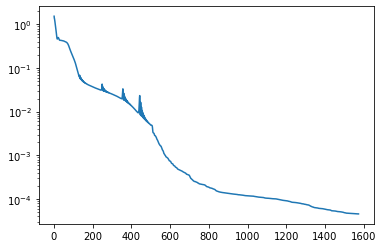

In [121]:
lbfgs_num = 3000
adam_num = 500
train(NN, adam_num, lbfgs_num)  

In [30]:
import scipy.io

In [31]:
d = 0.2
c = 1

In [32]:
import numpy as np
import math as m
x_data = np.linspace([-1], [1], 100)
t_data = np.linspace([0], [1.0], 5000)

k = t_data[1]-t_data[0]
h = x_data[1]-x_data[0]

u_data_0 = [1]
for x in x_data[1:99]:
    u_data_0.append(1-m.sin(np.pi * x))
u_data_0.append(1)

u_data=[]
u_data.append(u_data_0)

In [33]:
#fdm
for i in range(len(t_data)-1):
    u_data_t=[float((1-2*d*(k/h**2))*u_data[i][0] + d*(k/h**2)*u_data[i][1] + d*(k/h**2)*u_data[i][-2] - (c*k/h)*(u_data[i][0]-u_data[i][-2]))]
    for s in range(1,len(x_data)-1):
        sol = float((1-2*d*(k/h**2))*u_data[i][s] + d*(k/h**2)*u_data[i][s+1] + d*(k/h**2)*u_data[i][s-1] - (c*k/h)*(u_data[i][s]-u_data[i][s-1]))
        u_data_t.append(sol)
    u_data_t.append(float((1-2*d*(k/h**2))*u_data[i][99] + d*(k/h**2)*u_data[i][1] + d*(k/h**2)*u_data[i][98] - (c*k/h)*(u_data[i][99]-u_data[i][98])))
    u_data.append(u_data_t)

In [34]:
h

array([0.02020202])

In [35]:
d*k/h**2

array([0.09802961])

In [36]:
c*k/h

array([0.00990198])

In [37]:
u_data = np.array(u_data)

In [38]:
import scipy.io
scipy.io.savemat('c_diffusion_data_2.mat', {'x': x_data,'t': t_data,'usol': u_data}) 

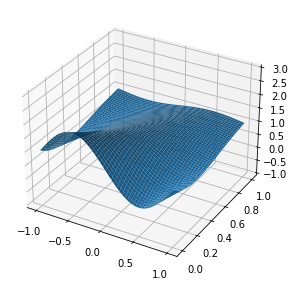

In [39]:
import scipy.io
data = scipy.io.loadmat('c_diffusion_data_2.mat')

t = data["t"].flatten() #2000
x = data["x"].flatten() #20
exact = np.real(data["usol"])

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([x for i in range(5000)])
Y = np.array([t for i in range(100)]).T
Z = exact



ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 3)
#ax.view_init(0, 0)
plt.tight_layout()
plt.show()

In [40]:
import scipy.io
data = scipy.io.loadmat('c_diffusion_data_2.mat')
t = data["t"].flatten()
x = data["x"].flatten()

pre_xt = []

for i in range(5000):
    for s in range(100):
        pre_xt.append([x[s], t[i]])

pre_xt = np.array(pre_xt)
pre_u = NN.predict(pre_xt)
pre = pre_u.reshape(5000, 100)

15625/15625 [==============================] - 24s 2ms/step


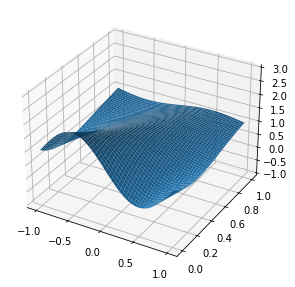

In [41]:
import scipy.io
data = scipy.io.loadmat('c_diffusion_data_2.mat')

t = data["t"].flatten() 
x = data["x"].flatten() 

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([x for i in range(5000)])
Y = np.array([t for i in range(100)]).T
Z = pre


ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 3)
#ax.view_init(0,0)
plt.tight_layout()
plt.show()

In [42]:
#relative_L2_error
round((np.linalg.norm(exact-pre, 2))/(np.linalg.norm(exact, 2)), 10)

0.0095530518

(0.0, 2.0)

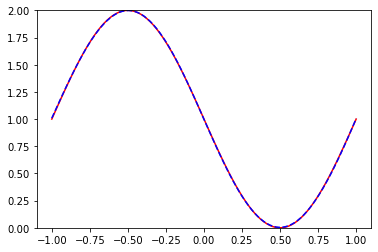

In [43]:
plt.plot(x, exact[0], color="red")
plt.plot(x, pre[0], color="blue", linestyle='--')
plt.ylim(0, 2)

(0.0, 2.0)

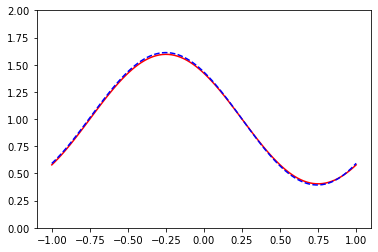

In [44]:
plt.plot(x, exact[1250], color="red")
plt.plot(x, pre[1250], color="blue", linestyle='--')
plt.ylim(0, 2)

(0.0, 2.0)

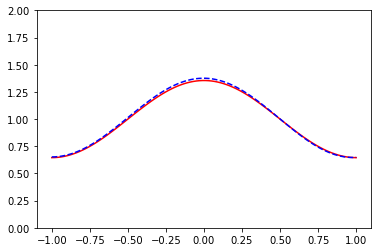

In [45]:
plt.plot(x, exact[2500], color="red")
plt.plot(x, pre[2500], color="blue", linestyle='--')
plt.ylim(0, 2)

(0.0, 2.0)

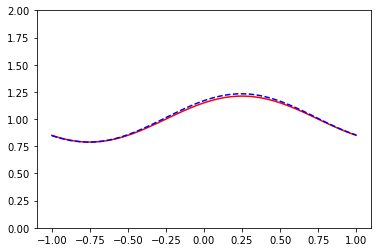

In [46]:
plt.plot(x, exact[3750], color="red")
plt.plot(x, pre[3750], color="blue", linestyle='--')
plt.ylim(0, 2)

(0.0, 2.0)

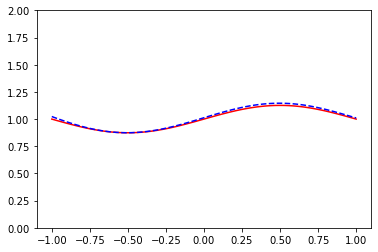

In [47]:
plt.plot(x, exact[-1], color="red")
plt.plot(x, pre[-1], color="blue", linestyle='--')
plt.ylim(0, 2)

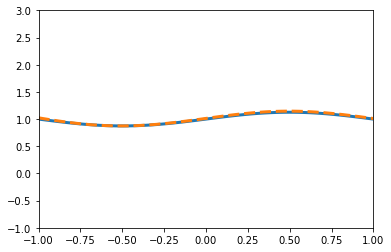

In [48]:
# 그래프 애니메이션

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
fig, ax = plt.subplots()

ax.set_xlim(( -1, 1))
ax.set_ylim((-1, 3))

line1, = ax.plot([], [], lw=3)
line2, = ax.plot([], [], lw=3, linestyle = '--')

def init1():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2,)

def animate1(i):
    x = np.linspace(-1, 1, 100)
    y_1 = exact[i]
    y_2 = pre[i]
    line1.set_data(x, y_1)
    line2.set_data(x, y_2)
    return (line1,)

anim1 = animation.FuncAnimation(fig, animate1, init_func=init1,
                               frames=5000, interval=15, blit=True)

rc('animation', html='html5')
#anim.save('exact.gif', writer='imagemagick')
anim1